# PCL Experiment Notebook

Train algorithms on increasing dataset sizes and plot risk/likelihood.

## Setup

Environment, imports, device selection, and reproducibility seeds.

In [1]:
# Imports and path setup
import sys
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

# Add project root to path if needed (before importing project modules)
sys.path.append(str(Path('..').resolve()))

from subpopbench.dataset import datasets
from subpopbench.learning import algorithms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from itertools import cycle
from subpopbench import hparams_registry
from subpopbench.utils.eval_helper import eval_metrics

# Select device: use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(0)

Using device: cuda


In [2]:
# Utility functions for robust error handling
import logging
import warnings
# Configure logging for better error tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import utility functions from misc.py
from subpopbench.utils.misc import safe_tensor_operation, safe_model_operation, check_data_validity, log_error, print_error_summary, group_counts

print("Utility functions for robust error handling loaded successfully.")

Utility functions for robust error handling loaded successfully.


## Experiment configuration

Dataset choice, learners, and result containers.

In [ ]:
DEBUG = True

# Experiment config
DATASET_NAME = 'CMNIST'
DATA_PATH = '/home/mila/t/tom.marty/scratch/data/benchmark'
LEARNERS =  ['GroupDRO','ERM','IRM'] # ['GroupDRO','ERM','CRT', 'DFR', 'IRM','ReSample']  # invariant learners to compare
NETWORK_NAME = 'ResNet'  # used in title; Algorithm builds its own network
USE_STRATIFIED = True # Toggle: use stratified (label, attr) sampling such that the class ratio is preserved



# Early stopping configuration
ES_MIN_DELTA = 0.0       # minimum improvement to reset 
ES_PATIENCE = 3         # checkpoints without improvement before stopping
if DEBUG:
    ES_PATIENCE = 0
    LEARNERS = ['ERM']  # only run ERM in debug mode 


print('Config:')
print(f'  Dataset: {DATASET_NAME}')
print(f'  Learners: {LEARNERS}')
print(f'  Data path: {DATA_PATH}')
print(f'  Stratified sampling: {USE_STRATIFIED}')
print(f'  Debug mode: {DEBUG}')

# Prepare per-learner results storage
val_loss_map = {alg: [] for alg in LEARNERS}           # validation loss means (best)
train_loss_map = {alg: [] for alg in LEARNERS}        # training loss mean (per size)
test_loss_map  = {alg: [] for alg in LEARNERS}        # test loss means (final model)
test_acc_map = {alg: [] for alg in LEARNERS}          # test accuracy
worst_group_acc_map = {alg: [] for alg in LEARNERS}   # test worst-group accuracy


Config:
  Dataset: CMNIST
  Learners: ['GroupDRO', 'ERM', 'IRM']
  Data path: /home/mila/t/tom.marty/scratch/data/benchmark
  Stratified sampling: True
  Debug mode: True


In [4]:
# Robust training configuration
ROBUST_TRAINING = True  # Enable robust error handling
MAX_RETRIES = 3  # Maximum number of retries for failed operations
CONTINUE_ON_ERROR = True  # Continue with next algorithm/size if current fails
SAVE_PARTIAL_RESULTS = True  # Save results even if some experiments fail

# Enhanced error tracking
ERROR_LOG = {
    'algorithm_failures': {},
    'size_failures': {},
    'step_failures': {},
    'validation_failures': {},
    'test_failures': {}
}

print(f"Robust training configuration loaded. Robust mode: {ROBUST_TRAINING}")

Robust training configuration loaded. Robust mode: True


## Hyperparameters

Defaults and dataset-specific overrides.

In [5]:
# Hyperparameters template
import os

# We'll derive specific hparams per learner in the training loop
base_hparams = hparams_registry.default_hparams('ERM', DATASET_NAME)
base_hparams.update({
    'image_arch': 'resnet_sup_in1k',
    'text_arch': 'bert-base-uncased',
})

cmnist_attr_prob = float(os.environ.get("CMNIST_ATTR_PROB", 0.1)) # attribute imbalance
cmnist_spur_prob = float(os.environ.get("CMNIST_SPUR_PROB", 0.1)) #control summed diagonal proportion (0,1) and (1,0) represent 10% of the dataset
if DATASET_NAME == 'CMNIST':
    base_hparams.update({
        'cmnist_label_prob': 0.5,
        'cmnist_attr_prob': cmnist_attr_prob, 
        'cmnist_spur_prob': cmnist_spur_prob,
        'cmnist_flip_prob': 0.0,
    })

print('Hparams template (subset):')
for k in ['image_arch', 'text_arch']:
    print(f'  {k}: {base_hparams[k]}')

Hparams template (subset):
  image_arch: resnet_sup_in1k
  text_arch: bert-base-uncased


## Datasets

Load train/val/test splits and preview samples.

  Train sizes: [10, 100]
100
Datasets:
  Train size: 100 | Val size: 100 | Test size: 100 (restricted)
  Input shape: (3, 224, 224) | data_type: images
  num_labels: 2 | num_attributes: 2


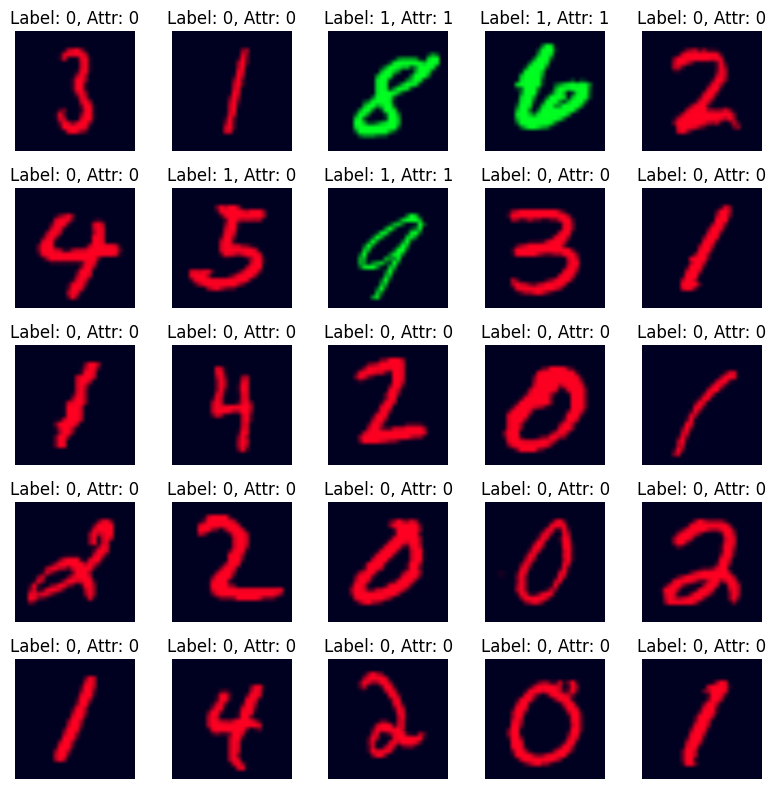

In [6]:
# Datasets
DatasetClass = getattr(datasets, DATASET_NAME)
train_dataset = DatasetClass(DATA_PATH, 'tr', base_hparams)
val_dataset_full = DatasetClass(DATA_PATH, 'va', base_hparams)
test_dataset = DatasetClass(DATA_PATH, 'te', base_hparams)

# If debug, reduce all datasets to size 100
if DEBUG:
    train_indices = random.sample(range(len(train_dataset)), min(100, len(train_dataset)))
    val_indices = random.sample(range(len(val_dataset_full)), min(100, len(val_dataset_full)))
    test_indices = random.sample(range(len(test_dataset)), min(100, len(test_dataset)))
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset_full, val_indices)
    test_dataset = Subset(test_dataset, test_indices)
else:
    val_count = min(5000, len(val_dataset_full))
    val_indices = random.sample(range(len(val_dataset_full)), val_count)
    val_dataset = Subset(val_dataset_full, val_indices)

# Attach key attributes to Subset objects for easier access
def attach_dataset_attributes(subset):
    if hasattr(subset, 'dataset'):
        for attr in ['INPUT_SHAPE', 'num_labels', 'num_attributes', 'data_type', 'N_STEPS']:
            if hasattr(subset.dataset, attr):
                setattr(subset, attr, getattr(subset.dataset, attr))
attach_dataset_attributes(train_dataset)
attach_dataset_attributes(val_dataset)
attach_dataset_attributes(test_dataset)

max_train_size = len(train_dataset)
if DEBUG:
    dataset_sizes = [10, 100]
else:
    dataset_sizes = np.logspace(2, np.log10(max_train_size), num=5, dtype=int).tolist()
print(f'  Train sizes: {dataset_sizes}')
print(max_train_size)

indices = list(range(len(train_dataset)))
random.shuffle(indices)

input_shape = train_dataset.INPUT_SHAPE
num_labels = train_dataset.num_labels
num_attributes = train_dataset.num_attributes
data_type = getattr(train_dataset, 'data_type', 'images')

print('Datasets:')
print(f'  Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)} (restricted)')
print(f'  Input shape: {input_shape} | data_type: {data_type}')
print(f'  num_labels: {num_labels} | num_attributes: {num_attributes}')

# Preview a few samples (images only)
if data_type == 'images':
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    axes = axes.flatten()

    for k, ax in enumerate(axes):
        idx, x, y, a = train_dataset[k]
        # Scale per-image to [0,1] for visualization
        x_vis = x.detach().cpu()
        x_min, x_max = x_vis.min(), x_vis.max()
        x_vis = (x_vis - x_min) / (x_max - x_min + 1e-6)
        ax.imshow(x_vis.permute(1, 2, 0))
        ax.set_title(f'Label: {int(y)}, Attr: {int(a)}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Non-image dataset preview omitted.')

In [7]:
# Stratified sampling helpers (by (label, attr))
from collections import defaultdict

def build_group_index(ds):
    groups = defaultdict(list)
    ys = getattr(ds, 'labels', None)
    attrs = getattr(ds, 'attributes', None)
    if ys is not None and attrs is not None and len(ys) == len(ds) and len(attrs) == len(ds):
        for i in range(len(ds)):
            y_i = int(ys[i])
            a_i = int(attrs[i])
            groups[(y_i, a_i)].append(i)
    else:
        for i in range(len(ds)):
            try:
                _, _, y, a = ds[i]
                groups[(int(y), int(a))].append(i)
            except Exception:
                pass
    return groups

def w(groups, size, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    total = sum(len(ixs) for ixs in groups.values())
    if total == 0:
        return []
    desired = {}
    fracs = {}
    for g, ixs in groups.items():
        c = size * (len(ixs) / total)
        desired[g] = int(np.floor(c))
        fracs[g] = c - desired[g]
    rem = size - sum(desired.values())
    if rem > 0:
        for g in sorted(groups.keys(), key=lambda g: fracs[g], reverse=True)[:rem]:
            desired[g] += 1
    selected = []
    for g, k in desired.items():
        if k <= 0:
            continue
        ixs = groups[g]
        if k >= len(ixs):
            selected.extend(ixs)
        else:
            chosen = rng.choice(ixs, size=k, replace=False).tolist()
            selected.extend(chosen)
    random.shuffle(selected)
    return selected

if USE_STRATIFIED:
    group_to_indices = build_group_index(train_dataset)
    group_counts_dict = {k: len(v) for k, v in sorted(group_to_indices.items())}
    print('Stratified groups (counts):', group_counts_dict)

    # Aggregate counts for each class and attribute
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([{'class': k[0], 'attribute': k[1], 'count': v} for k, v in group_counts_dict.items()])
    class_counts = df.groupby('class')['count'].sum()
    attr_counts = df.groupby('attribute')['count'].sum()
    total = df['count'].sum()

    print('\nClass distribution:')
    class_dist = df.groupby('class')['count'].sum().to_frame()
    class_dist['percentage'] = (class_dist['count'] / total * 100).round(2)
    print(class_dist.to_string())

    print('\nAttribute distribution:')
    attr_dist = df.groupby('attribute')['count'].sum().to_frame()
    attr_dist['percentage'] = (attr_dist['count'] / total * 100).round(2)
    print(attr_dist.to_string())

    print('\nGroup (class, attribute) distribution:')
    group_dist = df.set_index(['class','attribute'])
    group_dist['percentage'] = (group_dist['count'] / total * 100).round(2)
    print(group_dist.to_string())

Stratified groups (counts): {(0, 0): 85, (0, 1): 1, (1, 0): 5, (1, 1): 9}

Class distribution:
       count  percentage
class                   
0         86        86.0
1         14        14.0

Attribute distribution:
           count  percentage
attribute                   
0             90        90.0
1             10        10.0

Group (class, attribute) distribution:
                 count  percentage
class attribute                   
0     0             85        85.0
      1              1         1.0
1     0              5         5.0
      1              9         9.0


### Stratified Sampling
If `USE_STRATIFIED` is True, each training subset for a given size is drawn approximately proportional to the (label, attr) group counts in the full training set using the helper `w(...)`. This helps maintain group balance across different subset sizes. Set `USE_STRATIFIED = False` to revert to the earlier simple prefix-based random subset selection.


In [8]:
# Run group coverage checks
_ = group_counts(train_dataset, 'train')
_ = group_counts(val_dataset, 'val')
_ = group_counts(test_dataset, 'test')

[train] size=100 | unique attrs=[0, 1] | unique labels=[0, 1]
[train] attr counts: {0: 90, 1: 10}
[train] label counts: {0: 86, 1: 14}
[train] (label, attr) counts: {(0, 0): 85, (0, 1): 1, (1, 0): 5, (1, 1): 9}
[val] size=100 | unique attrs=[0, 1] | unique labels=[0, 1]
[val] attr counts: {0: 87, 1: 13}
[val] label counts: {0: 81, 1: 19}
[val] (label, attr) counts: {(0, 0): 77, (0, 1): 4, (1, 0): 10, (1, 1): 9}
[test] size=100 | unique attrs=[0, 1] | unique labels=[0, 1]
[test] attr counts: {0: 91, 1: 9}
[test] label counts: {0: 87, 1: 13}
[test] (label, attr) counts: {(0, 0): 86, (0, 1): 1, (1, 0): 5, (1, 1): 8}


## Training and evaluation

Infinite loader training loop and validation CE computation.

In [ ]:
# Training and evaluation
from tqdm.notebook import tqdm  # Use notebook version for cleaner output
import os
import math
import time

# Use environment variable for timestamp if set, else fallback to current time
results_timestamp = os.environ.get('RESULTS_TIMESTAMP', time.strftime('%Y%m%d-%H%M%S'))
result_dir = os.path.join("results", results_timestamp)

def infinite_loader(dataset, batch_size=32, num_workers=0, shuffle=True):
    dl = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return cycle(dl)



# Use a single constant for training batch size
BATCH_SIZE = 64

# Helper function to safely extract loss value
def safe_extract_loss(loss_dict, default_value=float('nan')):
    """Safely extract loss value from algorithm output"""
    try:
        if isinstance(loss_dict, dict):
            if 'loss' in loss_dict:
                loss_val = loss_dict['loss']
            elif len(loss_dict) > 0:
                # Try to get the first numeric value from the dict
                loss_val = next(iter(loss_dict.values()))
            else:
                return default_value
        else:
            loss_val = loss_dict
        
        # Convert to float and check for validity
        loss_float = float(loss_val)
        return loss_float if np.isfinite(loss_float) else default_value
    except (TypeError, ValueError, AttributeError):
        return default_value

# Helper function to safely compute metrics
def safe_mean(values, default_value=float('nan')):
    """Safely compute mean, handling empty lists and NaN values"""
    try:
        if not values:
            return default_value
        valid_values = [v for v in values if np.isfinite(v)]
        return float(np.mean(valid_values)) if valid_values else default_value
    except (TypeError, ValueError):
        return default_value

# === Main Experiment Loop ===
# For each algorithm, train on increasing dataset sizes, track metrics, and save/load best model.
for ALGO_NAME in LEARNERS:
    print(f"\n=== Learner: {ALGO_NAME} ===")
    
    try:
        # --- Setup hyperparameters for current algorithm ---
        hparams = hparams_registry.default_hparams(ALGO_NAME, DATASET_NAME)
        hparams.update(base_hparams)

        # --- Reset metric containers for current algorithm ---
        val_loss_map[ALGO_NAME] = []
        train_loss_map[ALGO_NAME] = []
        test_loss_map[ALGO_NAME] = []
        worst_group_acc_map[ALGO_NAME] = []
        test_acc_map[ALGO_NAME] = []

        # --- Loop over different training set sizes ---
        for size in dataset_sizes:
            print(f"\n--- Training {ALGO_NAME} with size={size} ---")
            
            try:
                # Prepare data subset for current size
                if USE_STRATIFIED:
                    subset_indices = w(group_to_indices, size, rng=np.random.default_rng(0 + size))
                else:
                    subset_indices = indices[:size]
                subset = Subset(train_dataset, subset_indices)
                train_minibatches_iterator = infinite_loader(subset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

                # --- Initialize algorithm/model ---
                # Attach attributes to subset for convenience
                if hasattr(subset, 'dataset'):
                    for attr in ['INPUT_SHAPE', 'num_labels', 'num_attributes', 'data_type', 'N_STEPS']:
                        if hasattr(subset.dataset, attr):
                            setattr(subset, attr, getattr(subset.dataset, attr))

                input_shape = train_dataset.INPUT_SHAPE
                num_labels = train_dataset.num_labels
                num_attributes = train_dataset.num_attributes
                data_type = getattr(train_dataset, 'data_type', 'images')

                AlgorithmClass = algorithms.get_algorithm_class(ALGO_NAME)
                algo = AlgorithmClass(data_type, input_shape, num_labels, num_attributes, len(subset), hparams)
                if hasattr(algo, 'to'):
                    algo = algo.to(DEVICE)

                print(f"[Init] size={size} | algo={ALGO_NAME} | data_type={data_type} | input_shape={input_shape} | labels={num_labels} | attrs={num_attributes} | stratified={USE_STRATIFIED}")

                # --- Training loop with early stopping ---
                n_steps = getattr(train_dataset, 'N_STEPS', size)
                # Evaluate once per epoch with the infinite loader
                checkpoint_freq = max(1, math.ceil(len(subset) / BATCH_SIZE))
                # Align total steps to a whole number of epochs (at least one)
                n_steps = max(checkpoint_freq, (n_steps // checkpoint_freq) * checkpoint_freq)

                best_val = float('inf')
                bad_checks = 0

                # Path to save best model for this algorithm and size
                ckpt_dir = os.path.join(result_dir, 'checkpoints', ALGO_NAME)
                os.makedirs(ckpt_dir, exist_ok=True)
                best_model_path = os.path.join(ckpt_dir, f'best_model_{ALGO_NAME}_size{size}.pt')

                # track training losses for this size
                train_losses_epoch = []

                algo.train()
                pbar = tqdm(range(n_steps), desc=f"Train size={size} ({ALGO_NAME})", leave=False)
                
                for step in pbar:
                    try:
                        # --- Training step ---
                        i, x, y, a = next(train_minibatches_iterator)
                        x, y, a = x.to(DEVICE), y.to(DEVICE), a.to(DEVICE)
                        
                        # Robust training step with error handling
                        try:
                            loss_dict = algo.update((i, x, y, a), step)
                            cur_loss = safe_extract_loss(loss_dict)
                            train_losses_epoch.append(cur_loss)
                            # Log step-level details to file only (not stdout)
                            logger.info(f"Step {step} | Algo: {ALGO_NAME} | Size: {size} | Train loss: {cur_loss}")
                        except Exception as e:
                            logger.warning(f"[Warning] Training step {step} failed: {e}")
                            cur_loss = float('nan')
                            train_losses_epoch.append(cur_loss)

                        # --- Validation checkpoint (once per epoch) ---
                        do_check = ((step + 1) % checkpoint_freq == 0)
                        if do_check:
                            try:
                                algo.eval()
                                val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
                                val_losses_step = []
                                val_acc_step = []
                                
                                with torch.no_grad():
                                    for i_val, x_val, y_val, a_val in val_loader:
                                        try:
                                            x_val, y_val, a_val = x_val.to(DEVICE), y_val.to(DEVICE), a_val.to(DEVICE)
                                            y_pred, vloss = algo.predict(x_val, y_val, return_loss=True)
                                            
                                            # Safely extract validation loss
                                            vloss_safe = safe_extract_loss(vloss)
                                            val_losses_step.append(vloss_safe)
                                            
                                            # Safely compute accuracy
                                            try:
                                                if hasattr(algo, 'predict_labels'):
                                                    y_hat = algo.predict_labels(x_val)
                                                else:
                                                    y_hat = y_pred.argmax(dim=-1) if y_pred.ndim > 1 else (y_pred > 0.5).long()
                                                acc = float((y_hat == y_val).float().mean().item())
                                                val_acc_step.append(acc)
                                            except Exception as e:
                                                logger.warning(f"[Warning] Accuracy computation failed: {e}")
                                                val_acc_step.append(float('nan'))
                                        except Exception as e:
                                            logger.warning(f"[Warning] Validation batch failed: {e}")
                                            val_losses_step.append(float('nan'))
                                            val_acc_step.append(float('nan'))

                                mean_val_loss = safe_mean(val_losses_step)
                                mean_val_acc = safe_mean(val_acc_step)

                                # --- Early stopping logic ---
                                if np.isfinite(mean_val_loss) and np.isfinite(best_val):
                                    improved = (best_val - mean_val_loss) > ES_MIN_DELTA
                                    if improved:
                                        best_val = mean_val_loss
                                        bad_checks = 0
                                        # Save best model checkpoint
                                        try:
                                            torch.save(algo.state_dict(), best_model_path)
                                        except Exception as e:
                                            logger.warning(f"[Warning] Failed to save checkpoint: {e}")
                                    else:
                                        bad_checks += 1
                                elif np.isfinite(mean_val_loss):
                                    # First valid validation loss
                                    best_val = mean_val_loss
                                    bad_checks = 0
                                    try:
                                        torch.save(algo.state_dict(), best_model_path)
                                    except Exception as e:
                                        logger.warning(f"[Warning] Failed to save checkpoint: {e}")

                                # Only print summary info to notebook output
                                pbar.set_postfix({
                                    'train_loss': cur_loss if np.isfinite(cur_loss) else 'NaN',
                                    'val_loss': mean_val_loss if np.isfinite(mean_val_loss) else 'NaN',
                                    'val_acc': mean_val_acc if np.isfinite(mean_val_acc) else 'NaN',
                                    'best_val': best_val if np.isfinite(best_val) else 'NaN',
                                    'pat': f"{bad_checks}/{ES_PATIENCE}"
                                })
                                algo.train()

                                if bad_checks >= ES_PATIENCE:
                                    print(f"[EarlyStop] size={size} | algo={ALGO_NAME} | step={step+1} | best_val={best_val:.4f}")
                                    break
                            except Exception as e:
                                logger.warning(f"[Warning] Validation checkpoint failed at step {step}: {e}")
                                algo.train()  # Ensure we're back in training mode
                    
                    except Exception as e:
                        logger.warning(f"[Warning] Step {step} failed entirely: {e}")
                        continue

                # --- Store best validation metrics ---
                val_loss_map[ALGO_NAME].append(best_val if np.isfinite(best_val) else float('nan'))
                # store mean train loss for this size
                train_loss_map[ALGO_NAME].append(safe_mean(train_losses_epoch))

                # --- Load best model before test evaluation ---
                try:
                    if os.path.exists(best_model_path):
                        algo.load_state_dict(torch.load(best_model_path))
                        print(f"[Info] Loaded best model from {best_model_path}")
                    else:
                        print(f"[Warning] No checkpoint found at {best_model_path}, using current model")
                except Exception as e:
                    logger.warning(f"[Warning] Failed to load checkpoint: {e}")

                # --- Test evaluation and metric collection ---
                try:
                    algo.eval()
                    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
                    metrics = eval_metrics(algo, test_loader, DEVICE)
                    
                    # Safely extract test metrics
                    test_bce = float('nan')
                    test_acc = float('nan')
                    worst_group_acc = float('nan')
                    
                    if isinstance(metrics, dict):
                        overall_metrics = metrics.get('overall', {})
                        if isinstance(overall_metrics, dict):
                            test_bce = overall_metrics.get('BCE', float('nan'))
                            test_acc = overall_metrics.get('accuracy', float('nan'))
                        
                        min_group_metrics = metrics.get('min_group', {})
                        if isinstance(min_group_metrics, dict):
                            worst_group_acc = min_group_metrics.get('accuracy', float('nan'))
                
                    test_loss_map[ALGO_NAME].append(test_bce)
                    test_acc_map[ALGO_NAME].append(test_acc)
                    worst_group_acc_map[ALGO_NAME].append(worst_group_acc)
                    
                    print(f"[Test Results] size={size} | test_acc={test_acc:.4f} | worst_group_acc={worst_group_acc:.4f} | test_bce={test_bce:.4f}")
                
                except Exception as e:
                    logger.warning(f"[Warning] Test evaluation failed for {ALGO_NAME} size={size}: {e}")
                    test_loss_map[ALGO_NAME].append(float('nan'))
                    test_acc_map[ALGO_NAME].append(float('nan'))
                    worst_group_acc_map[ALGO_NAME].append(float('nan'))
            
            except Exception as e:
                logger.error(f"[Error] Training failed for {ALGO_NAME} size={size}: {e}")
                # Fill with NaN values to maintain consistency
                val_loss_map[ALGO_NAME].append(float('nan'))
                train_loss_map[ALGO_NAME].append(float('nan'))
                test_loss_map[ALGO_NAME].append(float('nan'))
                test_acc_map[ALGO_NAME].append(float('nan'))
                worst_group_acc_map[ALGO_NAME].append(float('nan'))
    
    except Exception as e:
        logger.error(f"[Error] Algorithm {ALGO_NAME} failed entirely: {e}")
        # Initialize empty lists if not already done
        for map_dict in [val_loss_map, train_loss_map, test_loss_map, test_acc_map, worst_group_acc_map]:
            if ALGO_NAME not in map_dict:
                map_dict[ALGO_NAME] = [float('nan')] * len(dataset_sizes)

print("\n=== Training Complete ===")


=== Learner: ERM ===

--- Training ERM with size=10 ---


[Init] size=10 | algo=ERM | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True


Train size=10 (ERM):   0%|          | 0/5001 [00:00<?, ?it/s]

2025-09-08 16:41:08,484 - INFO - Step 0 | Algo: ERM | Size: 10 | Train loss: 0.6592182517051697


[EarlyStop] size=10 | algo=ERM | step=1 | best_val=0.6271
[Info] Loaded best model from results/20250908-164107/checkpoints/ERM/best_model_ERM_size10.pt
[Test Results] size=10 | test_acc=0.8700 | worst_group_acc=0.0000 | test_bce=0.6171

--- Training ERM with size=100 ---
[Test Results] size=10 | test_acc=0.8700 | worst_group_acc=0.0000 | test_bce=0.6171

--- Training ERM with size=100 ---
[Init] size=100 | algo=ERM | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True
[Init] size=100 | algo=ERM | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True


Train size=100 (ERM):   0%|          | 0/5000 [00:00<?, ?it/s]

2025-09-08 16:41:09,820 - INFO - Step 0 | Algo: ERM | Size: 100 | Train loss: 0.8411622047424316
2025-09-08 16:41:09,983 - INFO - Step 1 | Algo: ERM | Size: 100 | Train loss: 0.7289764881134033
2025-09-08 16:41:09,983 - INFO - Step 1 | Algo: ERM | Size: 100 | Train loss: 0.7289764881134033


[EarlyStop] size=100 | algo=ERM | step=2 | best_val=0.6755
[Info] Loaded best model from results/20250908-164107/checkpoints/ERM/best_model_ERM_size100.pt
[Test Results] size=100 | test_acc=0.7800 | worst_group_acc=0.0000 | test_bce=0.6602

=== Training Complete ===
[Test Results] size=100 | test_acc=0.7800 | worst_group_acc=0.0000 | test_bce=0.6602

=== Training Complete ===


## Results and plots

Validation CE and training loss across learners and dataset sizes.

/tmp/ipykernel_763726/1782127195.py:97: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(x_vals, y_vals, '-o', label=f'{alg} Test Acc', color=alg_colors[alg], linestyle='-')
/tmp/ipykernel_763726/1782127195.py:105: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--s" (-> linestyle='--'). The keyword argument will take precedence.
  ax3.plot(x_vals, y_vals, '--s', label=f'{alg} Worst Group Acc', color=alg_colors[alg], linestyle='--')


[savefig] Saved figure to results/20250908-164107/plots/cmnist_summary_metrics_0.1_spur0.1.png
[Info] Plot saved successfully: results/20250908-164107/plots/cmnist_summary_metrics_0.1_spur0.1.png


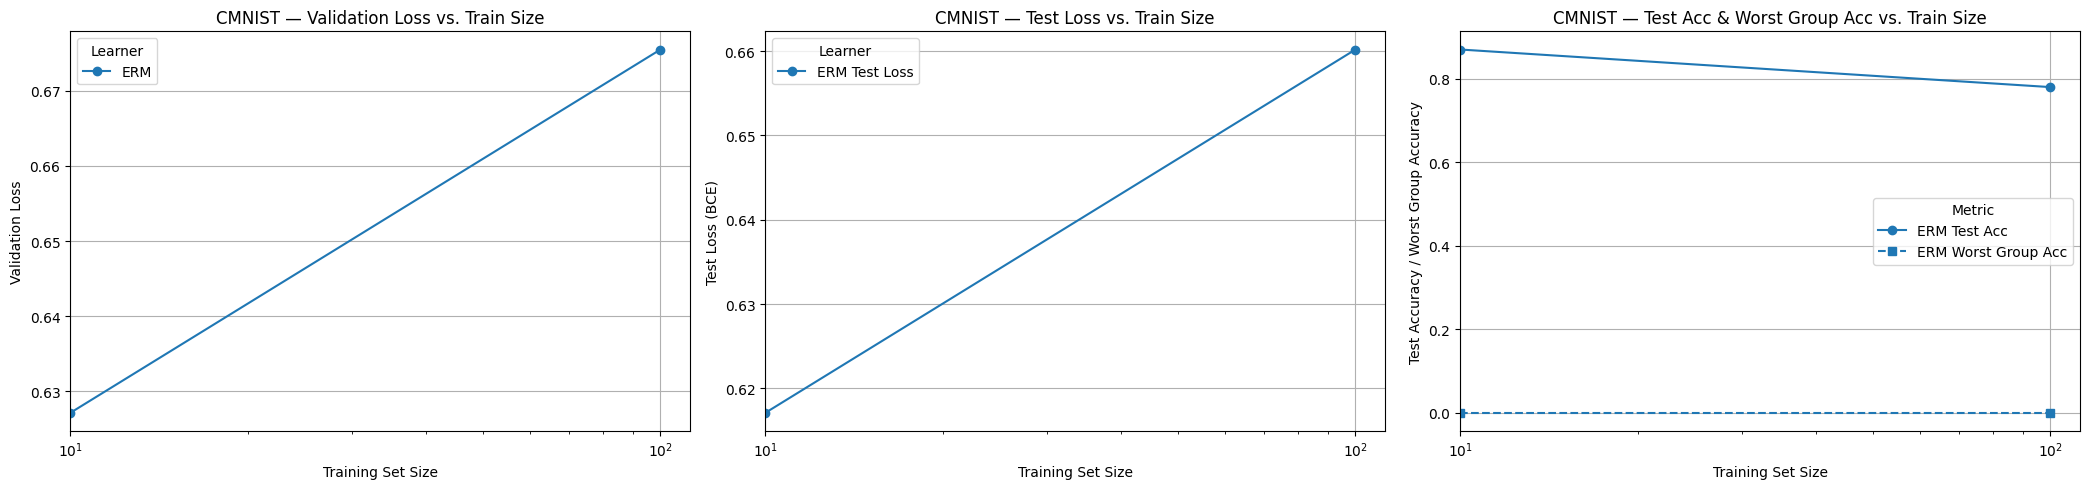

PCL curve results saved to results/20250908-164107/tables/pcl_curve_attr0p1_spur0p1.csv

=== Results Summary for CMNIST ===

ERM:
  Valid validation losses: 2/2
  Valid test accuracies: 2/2
  Valid worst group accuracies: 2/2
  Best test accuracy: 0.8700
  Best worst group accuracy: 0.0000


In [10]:
# Plot results
import itertools
from subpopbench.utils.plotting import savefig
import warnings
import os
import pandas as pd

# Helper function to filter out NaN values for plotting
def filter_finite_values(x_vals, y_vals):
    """Filter out NaN/inf values for plotting and align x/y lengths"""
    y_vals = np.array(y_vals)
    x_vals = np.array(x_vals[:len(y_vals)])  # Align x to y length
    finite_mask = np.isfinite(y_vals)
    return x_vals[finite_mask], y_vals[finite_mask]

fig, axes = plt.subplots(1, 3, figsize=(21, 5), sharex=True)

# Get color cycle for consistent coloring
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
alg_colors = {alg: next(color_cycle) for alg in LEARNERS}

# Prepare results DataFrame for PCL curve
pcl_records = []

# Validation loss
ax = axes[0]
for alg in LEARNERS:
    try:
        if alg in val_loss_map and val_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, val_loss_map[alg])
            test_loss_vals = test_loss_map.get(alg, [])
            test_acc_vals = test_acc_map.get(alg, [])
            worst_group_acc_vals = worst_group_acc_map.get(alg, [])
            for i, (x, y) in enumerate(zip(x_vals, y_vals)):
                # Use index i for corresponding test metrics
                test_loss = test_loss_vals[i] if i < len(test_loss_vals) else float('nan')
                test_acc = test_acc_vals[i] if i < len(test_acc_vals) else float('nan')
                worst_group_acc = worst_group_acc_vals[i] if i < len(worst_group_acc_vals) else float('nan')
                pcl_records.append({
                    'learner': alg,
                    'train_size': x,
                    'val_loss': y,
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                    'worst_group_acc': worst_group_acc,
                    'cmnist_attr_prob': base_hparams.get('cmnist_attr_prob'),
                    'cmnist_spur_prob': base_hparams.get('cmnist_spur_prob')
                })
            if len(x_vals) > 0:
                ax.errorbar(x_vals, y_vals, fmt='-o', capsize=4, label=alg, color=alg_colors[alg])
            else:
                print(f"[Warning] No valid validation loss data for {alg}")
        else:
            print(f"[Warning] No validation loss data found for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot validation loss for {alg}: {e}")

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_xlim(left=min(dataset_sizes))
ax.set_title(f'{DATASET_NAME} — Validation Loss vs. Train Size')
ax.grid(True)
ax.legend(title='Learner')

# Test loss (only overall test loss)
ax2 = axes[1]
for alg in LEARNERS:
    try:
        if alg in test_loss_map and test_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_loss_map[alg])
            if len(x_vals) > 0:
                ax2.errorbar(x_vals, y_vals, fmt='-o', capsize=4, label=f'{alg} Test Loss', color=alg_colors[alg])
            else:
                print(f"[Warning] No valid test loss data for {alg}")
        else:
            print(f"[Warning] No test loss data found for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot test loss for {alg}: {e}")

ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Test Loss (BCE)')
ax2.set_xscale('log')
ax2.set_xlim(left=min(dataset_sizes))
ax2.set_title(f'{DATASET_NAME} — Test Loss vs. Train Size')
ax2.grid(True)
ax2.legend(title='Learner')

# Test accuracy and worst-group accuracy
ax3 = axes[2]
for alg in LEARNERS:
    try:
        # Plot test accuracy
        if alg in test_acc_map and test_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '-o', label=f'{alg} Test Acc', color=alg_colors[alg], linestyle='-')
            else:
                print(f"[Warning] No valid test accuracy data for {alg}")
        
        # Plot worst group accuracy
        if alg in worst_group_acc_map and worst_group_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, worst_group_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '--s', label=f'{alg} Worst Group Acc', color=alg_colors[alg], linestyle='--')
            else:
                print(f"[Warning] No valid worst group accuracy data for {alg}")
                
    except Exception as e:
        print(f"[Warning] Failed to plot accuracy metrics for {alg}: {e}")

ax3.set_xlabel('Training Set Size')
ax3.set_ylabel('Test Accuracy / Worst Group Accuracy')
ax3.set_xscale('log')
ax3.set_xlim(left=min(dataset_sizes))
ax3.set_title(f'{DATASET_NAME} — Test Acc & Worst Group Acc vs. Train Size')
ax3.grid(True)
ax3.legend(title='Metric')

plt.tight_layout()

# Save figure with error handling
plot_dir = os.path.join(result_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, f'{DATASET_NAME.lower()}_summary_metrics_{base_hparams.get("cmnist_attr_prob")}_spur{base_hparams.get("cmnist_spur_prob")}.png')
try:
    savefig(plot_path, fig=fig)
    print(f"[Info] Plot saved successfully: {plot_path}")
except Exception as e:
    print(f"[Warning] Failed to save plot: {e}")

plt.show()

# Save PCL curve results to CSV
table_dir = os.path.join(result_dir, "tables")
os.makedirs(table_dir, exist_ok=True)
attr_prob_str = str(base_hparams.get('cmnist_attr_prob')).replace('.', 'p')
spur_prob_str = str(base_hparams.get('cmnist_spur_prob')).replace('.', 'p')
csv_filename = f"{table_dir}/pcl_curve_attr{attr_prob_str}_spur{spur_prob_str}.csv"
pcl_df = pd.DataFrame(pcl_records)
pcl_df.to_csv(csv_filename, index=False)
print(f"PCL curve results saved to {csv_filename}")

# Print summary of results
print(f"\n=== Results Summary for {DATASET_NAME} ===")
for alg in LEARNERS:
    print(f"\n{alg}:")
    try:
        valid_val_losses = [x for x in val_loss_map.get(alg, []) if np.isfinite(x)]
        valid_test_accs = [x for x in test_acc_map.get(alg, []) if np.isfinite(x)]
        valid_worst_accs = [x for x in worst_group_acc_map.get(alg, []) if np.isfinite(x)]
        
        print(f"  Valid validation losses: {len(valid_val_losses)}/{len(dataset_sizes)}")
        print(f"  Valid test accuracies: {len(valid_test_accs)}/{len(dataset_sizes)}")
        print(f"  Valid worst group accuracies: {len(valid_worst_accs)}/{len(dataset_sizes)}")
        
        if valid_test_accs:
            print(f"  Best test accuracy: {max(valid_test_accs):.4f}")
        if valid_worst_accs:
            print(f"  Best worst group accuracy: {max(valid_worst_accs):.4f}")
    except Exception as e:
        print(f"  Error computing summary: {e}")

In [11]:
import pickle
from datetime import datetime

# Print error summary and cleanup
print_error_summary(ERROR_LOG)

# Memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nGPU memory cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

try:
    # Also save a human-readable summary
    summary_file = os.path.join(result_dir, f"summary_{DATASET_NAME}.txt")
    with open(summary_file, 'w') as f:
        f.write(f"Experiment Summary - {DATASET_NAME}\n")
        f.write(f"Learners: {LEARNERS}\n")
        f.write(f"Dataset sizes: {dataset_sizes}\n\n")
        
        for alg in LEARNERS:
            f.write(f"\n{alg} Results:\n")
            f.write("-" * 20 + "\n")
            
            for i, size in enumerate(dataset_sizes):
                f.write(f"Size {size}:\n")
                f.write(f"  Val Loss: {val_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Test Acc: {test_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Worst Group Acc: {worst_group_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
        
        # Add error summary
        f.write(f"\n\nError Summary:\n")
        f.write("=" * 30 + "\n")
        total_errors = sum(len(errors) for error_dict in ERROR_LOG.values() for errors in error_dict.values())
        f.write(f"Total errors encountered: {total_errors}\n")
        
        for error_type, errors in ERROR_LOG.items():
            if errors:
                f.write(f"\n{error_type.replace('_', ' ').title()}:\n")
                for context, error_list in errors.items():
                    f.write(f"  {context}: {len(error_list)} errors\n")
    
    print(f"Summary saved to: {summary_file}")
    
except Exception as e:
    print(f"Warning: Failed to save summary: {e}")

print("\n=== Experiment Complete ===")


=== Error Summary ===
No errors encountered!

GPU memory cleared. Available memory: 47.8 GB
Summary saved to: results/20250908-164107/summary_CMNIST.txt

=== Experiment Complete ===

GPU memory cleared. Available memory: 47.8 GB
Summary saved to: results/20250908-164107/summary_CMNIST.txt

=== Experiment Complete ===


In [12]:
#  jupyter nbconvert --to notebook --execute subpopbench/pcl.ipynb --output executed_notebook.ipynb
# [NbConvertApp] Converting notebook subpopbench/pcl.ipynb to notebook